## Install Packages

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install facenet-pytorch

In [3]:
# requirements_file_path = "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt"

# !cat "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt" | xargs -n 1 pip install

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score
import src
from tqdm.notebook import tqdm
from src.utils.celeba_helper import CelebADataset, CelebAClassifier, save_file_names, CelebADatasetTriplet
from src.utils.loss_functions import TripletLoss
from imp import reload
import shutil

workers = 0 if os.name == 'nt' else 2

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define CelebA Dataset and Loader

In [6]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba'
mapping_file = 'data/identity_CelebA_train_test_split.txt'

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADatasetTriplet(img_folder, mapping_file, transform)

Image names size is: 202599


In [7]:
len(celeba_dataset.test_df)

192422

In [8]:
## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

# FaceNet Training Pipeline

## Initializing the resnet model, optimizer and loss function

In [9]:
margin = 0.5
resnet = InceptionResnetV1(pretrained='vggface2').to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
criterion = TripletLoss(margin=margin)

## Test before training

In [10]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]
print(test_anchor.shape)

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))
print(test_anchor[None, :].shape)

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

torch.Size([3, 160, 160])
torch.Size([1, 3, 160, 160])
The distance between anchor and positive: 0.8977565169334412
The distance between anchor and negative: 2.313505172729492


## Training steps

In [11]:
resnet.train()
epochs = 100
loss_total = []

for epoch in tqdm(range(epochs), desc="Epochs", leave=True, position=0):
    running_loss = []
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(celeba_dataloader, 
                                                desc="Training", position=1, leave=False)):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        if anchors.shape[0] == 1:
            continue

        optimizer.zero_grad()

        anchor_emb = resnet(anchors)
        positive_emb = resnet(positives)
        negative_emb = resnet(negatives)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        # print("loss is {}".format(loss))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
        # if step > 50:
        #     break
        
    loss_total.append(np.mean(running_loss))
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch, epochs, np.mean(running_loss)))


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0/100 - Loss: 0.0404


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1/100 - Loss: 0.0348


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2/100 - Loss: 0.0304


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3/100 - Loss: 0.0321


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4/100 - Loss: 0.0312


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5/100 - Loss: 0.0304


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6/100 - Loss: 0.0268


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7/100 - Loss: 0.0283


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8/100 - Loss: 0.0260


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9/100 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 10/100 - Loss: 0.0263


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 11/100 - Loss: 0.0254


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 12/100 - Loss: 0.0249


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 13/100 - Loss: 0.0235


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 14/100 - Loss: 0.0231


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 15/100 - Loss: 0.0220


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 16/100 - Loss: 0.0220


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 17/100 - Loss: 0.0212


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 18/100 - Loss: 0.0214


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 19/100 - Loss: 0.0199


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 20/100 - Loss: 0.0211


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 21/100 - Loss: 0.0212


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 22/100 - Loss: 0.0225


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 23/100 - Loss: 0.0214


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 24/100 - Loss: 0.0218


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 25/100 - Loss: 0.0209


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 26/100 - Loss: 0.0196


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 27/100 - Loss: 0.0197


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 28/100 - Loss: 0.0185


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 29/100 - Loss: 0.0183


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 30/100 - Loss: 0.0177


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 31/100 - Loss: 0.0189


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 32/100 - Loss: 0.0189


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 33/100 - Loss: 0.0181


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 34/100 - Loss: 0.0176


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 35/100 - Loss: 0.0174


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 36/100 - Loss: 0.0186


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 37/100 - Loss: 0.0185


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 38/100 - Loss: 0.0170


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 39/100 - Loss: 0.0148


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 40/100 - Loss: 0.0171


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 41/100 - Loss: 0.0166


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 42/100 - Loss: 0.0157


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 43/100 - Loss: 0.0146


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 44/100 - Loss: 0.0144


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 45/100 - Loss: 0.0150


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 46/100 - Loss: 0.0157


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 47/100 - Loss: 0.0134


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 48/100 - Loss: 0.0153


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 49/100 - Loss: 0.0152


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 50/100 - Loss: 0.0162


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 51/100 - Loss: 0.0150


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 52/100 - Loss: 0.0140


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 53/100 - Loss: 0.0182


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 54/100 - Loss: 0.0145


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 55/100 - Loss: 0.0162


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 56/100 - Loss: 0.0133


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 57/100 - Loss: 0.0124


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 58/100 - Loss: 0.0117


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 59/100 - Loss: 0.0111


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 60/100 - Loss: 0.0132


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 61/100 - Loss: 0.0129


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 62/100 - Loss: 0.0105


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 63/100 - Loss: 0.0121


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 64/100 - Loss: 0.0123


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 65/100 - Loss: 0.0117


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 66/100 - Loss: 0.0132


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 67/100 - Loss: 0.0123


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 68/100 - Loss: 0.0105


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 69/100 - Loss: 0.0135


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 70/100 - Loss: 0.0122


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 71/100 - Loss: 0.0116


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 72/100 - Loss: 0.0093


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 73/100 - Loss: 0.0115


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 74/100 - Loss: 0.0130


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 75/100 - Loss: 0.0100


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 76/100 - Loss: 0.0118


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 77/100 - Loss: 0.0100


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 78/100 - Loss: 0.0107


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 79/100 - Loss: 0.0099


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 80/100 - Loss: 0.0091


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 81/100 - Loss: 0.0097


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 82/100 - Loss: 0.0119


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 83/100 - Loss: 0.0096


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 84/100 - Loss: 0.0100


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 85/100 - Loss: 0.0106


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 86/100 - Loss: 0.0120


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 87/100 - Loss: 0.0100


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 88/100 - Loss: 0.0131


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 89/100 - Loss: 0.0105


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 90/100 - Loss: 0.0106


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 91/100 - Loss: 0.0105


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 92/100 - Loss: 0.0111


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 93/100 - Loss: 0.0112


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 94/100 - Loss: 0.0082


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 95/100 - Loss: 0.0089


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 96/100 - Loss: 0.0102


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 97/100 - Loss: 0.0108


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 98/100 - Loss: 0.0102


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 99/100 - Loss: 0.0110


## Plotting Loss curve

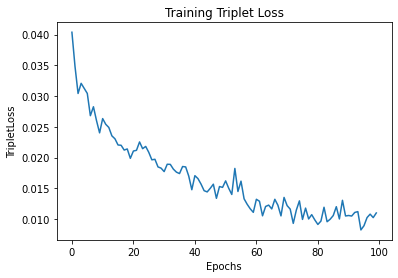

In [12]:
# printing loss function
plt.plot(loss_total)
plt.xlabel("Epochs")
plt.ylabel("TripletLoss")
plt.title("Training Triplet Loss")
plt.show()

In [13]:
model_path = f"models/facenet_model_epochs{epochs}_margin{margin}.pth"
if not os.path.exists(model_path):
    torch.save(resnet, model_path)

In [14]:
model_state_path = f"models/facenet_model_statedict_epochs{epochs}_margin{margin}.pth"
if not os.path.exists(model_state_path):
    torch.save(resnet.state_dict(), model_state_path)

In [15]:
# resnet = torch.load(model_path)

## Testing the trained model:

In [16]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

The distance between anchor and positive: 0.31431031227111816
The distance between anchor and negative: 2.5333805084228516


In [17]:
test_anchor_emb.shape

torch.Size([1, 512])

## Accuracy of the model

In [18]:
celeba_dataset.train_df.head()

,file_name,person_id,is_train
0,000001.jpg,2880,1
1,000002.jpg,2937,1
2,000003.jpg,8692,1
3,000004.jpg,5805,1
4,000005.jpg,9295,1


In [19]:
celeba_dataset.train_df.iloc[0]["file_name"]

'000001.jpg'

## Creating Vault folder and vault mapping file

In [20]:
vault_path = "data/oneshot_vault"
label_file = "data/identity_vault_person.txt"

In [21]:
# creating the vault and test label file
if not os.path.exists(vault_path):
    os.makedirs(vault_path)

    # copying train images in the vault location and appending the label file
    with open(label_file, "w") as v_file:
        for i in range(len(celeba_dataset)):
            file = celeba_dataset.train_df.iloc[i]["file_name"]
            label = str(celeba_dataset.train_df.iloc[i]["person_id"])
            v_file.write(file+" "+label+"\n")

            # copying the file to the new folder
            src_file = os.path.join(img_folder, file)
            dst_file = os.path.join(vault_path, file)
            shutil.copy(src_file, dst_file)
        

### Creating vault embeddings or load vault embeddings if already created

In [22]:
# function to create embeddings    
def create_embeddings(celeba_dataloader, model):
    # initializing embedding vector and gt_label list
    embeddings = torch.tensor([])
    gt_labels = []
    
    # creating embeddings 
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(celeba_dataloader, 
                                                            desc="Training", position=1)):
        anchors = anchors.to(device)
        img_embs = model(anchors).detach().cpu()
        
        embeddings = torch.cat([embeddings, img_embs])
        gt_labels.extend(labels)

    return embeddings, gt_labels

In [23]:
vault_embeddings_file = f"pytorch_objects/vault_embeddings_epochs{epochs}_margin{margin}.pickle"
vault_gt_labels_file = f"pytorch_objects/vault_gt_labels_epochs{epochs}_margin{margin}.pickle"

# setting model to eval mode
resnet.eval().to(device)

if not os.path.exists(vault_embeddings_file) or not os.path.exists(vault_gt_labels_file):
    embeddings, gt_labels = create_embeddings(celeba_dataloader = celeba_dataloader,
                                              model = resnet)
    
    torch.save(embeddings, vault_embeddings_file)
    torch.save(gt_labels, vault_gt_labels_file)
else:
    embeddings = torch.load(vault_embeddings_file)
    gt_labels = torch.load(vault_gt_labels_file)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

In [24]:
# if not torch.is_tensor(gt_labels):
#     gt_labels = torch.tensor(gt_labels).to(device)
# else:
#     gt_labels = gt_labels.to(device)
# gt_labels.shape

In [25]:
%%time
from sklearn.neighbors import KNeighborsClassifier
embeddings = embeddings.detach().cpu()
# gt_labels = gt_labels.detach().cpu()
gt_labels = torch.tensor(gt_labels)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(embeddings, gt_labels)
# score = knn.score(test_embeddings, test_labels)

# print(f'Pre-trained model: Accuracy = {score}.')

CPU times: user 49.9 ms, sys: 0 ns, total: 49.9 ms
Wall time: 49.2 ms


KNeighborsClassifier(n_neighbors=1)

In [26]:
# import torch
# a = torch.rand(2,3)[None,:].transpose(2,1)#[None,:].transpose(2,1)
# b = torch.rand(4,3)[:, :, None]#.transpose(2,1)
# c=a-b
# print(f"a is: {a}")
# print(f"b is: {b}")

In [27]:
a = torch.rand(1,512)

In [28]:
# d = c.pow(2).sum(axis=1).transpose(1,0)
# torch.argmin(d, axis=1)

In [29]:
# Test image:

def calculate_label(test_images, embeddings, gt_labels, embedding_model):
    # test_image_file = "s1_9.pgm"
    test_images = test_images.to(device)

    test_img_emb = embedding_model(test_images).detach().cpu()
    test_img_emb = test_img_emb[None,:].transpose(2,1).to(device)

    distance_mat = (test_img_emb - embeddings).pow(2).sum(axis=1).transpose(1,0)
    test_label_pred = gt_labels[torch.argmin(distance_mat, axis=1)]

    return test_label_pred


In [30]:
gt_labels.device

device(type='cpu')

In [31]:
# celeba_dataset.is_train = False
# # test_gt_labels = torch.tensor([]).type(torch.int)

# test_imgs, test_labels = next(iter(celeba_dataloader))
# print(f"Shape of test_imgs: {test_imgs.shape}")
# print(f"test labels: {test_labels}")

# # test_gt_labels = torch.cat([test_gt_labels, test_labels])
# calculate_label(test_imgs, embeddings_, torch.tensor(gt_labels))

In [32]:
torch.is_tensor(gt_labels)

True

In [33]:
celeba_dataset.is_train = False

test_predictions = torch.tensor([]).type(torch.int)
test_gt_labels = torch.tensor([]).type(torch.int)

test_embeddings = torch.tensor([])

# if not torch.is_tensor(gt_labels):
#     gt_labels = torch.tensor(gt_labels).to(device)
# else:
#     gt_labels = gt_labels.to(device)
gt_labels = gt_labels.detach().cpu()

# embeddings_ = embeddings[:, :, None].to(device)

for i, (test_imgs, test_labels) in enumerate(tqdm(celeba_dataloader, 
                                desc="Training", position=1, leave=False)):
    test_gt_labels = torch.cat([test_gt_labels, test_labels])
    
    #new
    test_imgs = test_imgs.to(device)
    test_embs = resnet(test_imgs).detach().cpu()
    test_embeddings = torch.cat([test_embeddings, test_embs])
    
#     test_pred_labels = calculate_label(test_images = test_imgs, embeddings = embeddings_,
#                                        gt_labels=gt_labels, embedding_model=resnet).detach().cpu()
    
#     test_predictions = torch.cat([test_predictions, test_pred_labels])
    
    if i>200:
        break

Training:   0%|          | 0/1504 [00:00<?, ?it/s]

In [34]:
test_embeddings_file = f"pytorch_objects/test_embeddings_epochs_epochs{epochs}_margin{margin}.pickle"
test_gt_labels_file = f"pytorch_objects/test_gt_labels_epochs{epochs}_margin{margin}.pickle"

torch.save(test_embeddings, test_embeddings_file)
torch.save(test_gt_labels, test_gt_labels_file)

In [35]:
score = knn.score(test_embeddings, test_gt_labels)

print(f'trained model: Accuracy = {score}.')
# margin 0.2: trained model: Accuracy = 0.1463490099009901.

trained model: Accuracy = 0.33489325495049505.


In [36]:
# accuracy = test_predictions == test_gt_labels
# accuracy = accuracy.int().sum()/len(accuracy)
# print(f'Accuracy for the model: {accuracy}')



In [37]:
test_predictions[:10]

tensor([], dtype=torch.int32)

In [38]:
test_gt_labels[:10]

tensor([1058, 4407, 3602, 3422, 4960, 7434, 4960,  290, 2522,  167])